<a href="https://colab.research.google.com/github/paulantoine/covid_dept/blob/master/covid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import requests
import bs4 as BeautifulSoup
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight') #'seaborn-notebook'
plt.rcParams.update({'font.size': 14})

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
url = "https://www.data.gouv.fr/fr/datasets/donnees-hospitalieres-relatives-a-lepidemie-de-covid-19/"
r = requests.get(url)
soup = BeautifulSoup.BeautifulSoup(r.text)
ressources_list = soup.find("div", "resources-list")
url = None
for article in ressources_list.find_all("article"):
  if 'donnees-hospitalieres-nouveaux-covid19' in article.div.h4.text:
    url = article.find("a", "btn btn-sm btn-primary", download=True)["href"]
    break
if url == None:
  raise("data not found")
df = pd.read_csv(url, sep=";")
df.tail()


,dep,jour,incid_hosp,incid_rea,incid_dc,incid_rad
5146,976,2020-05-04,11,1,1,5
5147,976,2020-05-05,7,2,2,3
5148,976,2020-05-06,8,1,1,6
5149,976,2020-05-07,11,1,0,4
5150,976,2020-05-08,6,2,0,3


In [0]:
def display_dept(d_number, d_name):
    dept = df[df.dep==d_number]
    dept.set_index(dept.jour, inplace=True)
    plt.figure(figsize=(15,8))
    plt.plot(dept[["incid_hosp", "incid_rea"]], marker="o")
    plt.xticks(rotation=75)
    plt.title(d_name, fontsize=22)
    plt.legend(["hospitalisations", "réanimations"], loc=2, fontsize=14)
    plt.show()
    print(dept.tail())

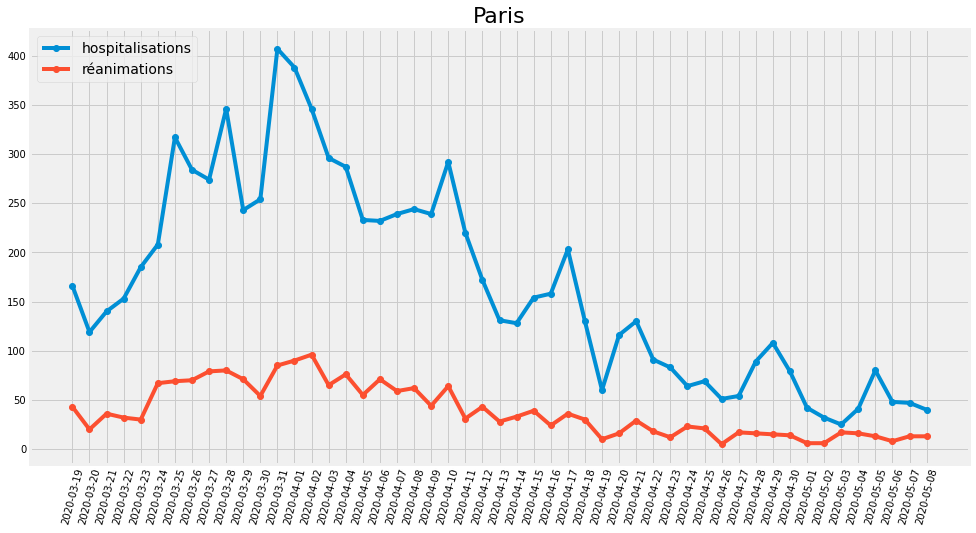

           dep        jour  incid_hosp  incid_rea  incid_dc  incid_rad
jour                                                                  
2020-05-04  75  2020-05-04          41         16        24         32
2020-05-05  75  2020-05-05          80         13        25         94
2020-05-06  75  2020-05-06          48          8        13        130
2020-05-07  75  2020-05-07          47         13         8        131
2020-05-08  75  2020-05-08          40         13         2         69


In [4]:
display_dept("75", "Paris")

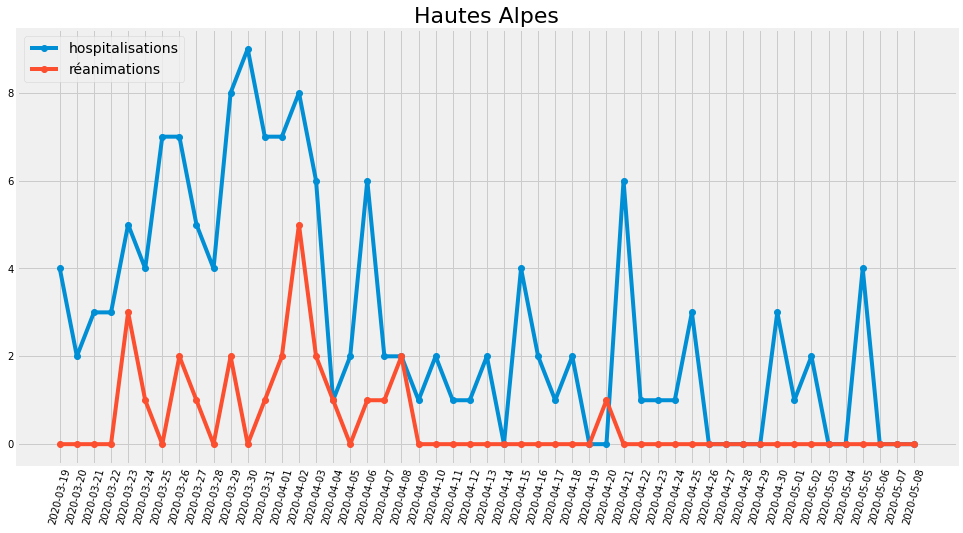

           dep        jour  incid_hosp  incid_rea  incid_dc  incid_rad
jour                                                                  
2020-05-04  05  2020-05-04           0          0         0          0
2020-05-05  05  2020-05-05           4          0         2          1
2020-05-06  05  2020-05-06           0          0         0          0
2020-05-07  05  2020-05-07           0          0         1          2
2020-05-08  05  2020-05-08           0          0         0          0


In [5]:
display_dept("05","Hautes Alpes")

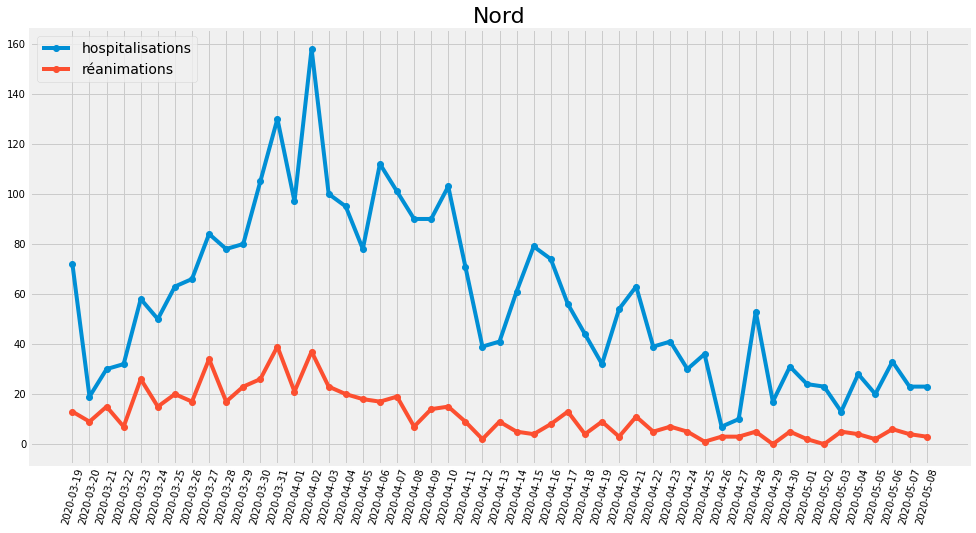

           dep        jour  incid_hosp  incid_rea  incid_dc  incid_rad
jour                                                                  
2020-05-04  59  2020-05-04          28          4         3          9
2020-05-05  59  2020-05-05          20          2        20         53
2020-05-06  59  2020-05-06          33          6        16         64
2020-05-07  59  2020-05-07          23          4         7         20
2020-05-08  59  2020-05-08          23          3         3         25


In [6]:
display_dept("59","Nord")

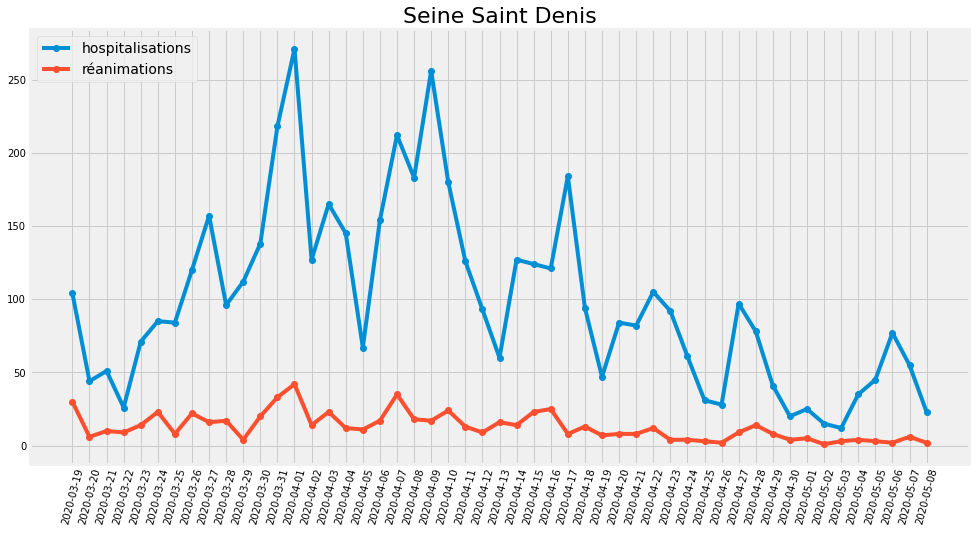

           dep        jour  incid_hosp  incid_rea  incid_dc  incid_rad
jour                                                                  
2020-05-04  93  2020-05-04          35          4        10         24
2020-05-05  93  2020-05-05          45          3         7         59
2020-05-06  93  2020-05-06          77          2         8         80
2020-05-07  93  2020-05-07          55          6         9         84
2020-05-08  93  2020-05-08          23          2         3         22


In [7]:
display_dept("93","Seine Saint Denis")

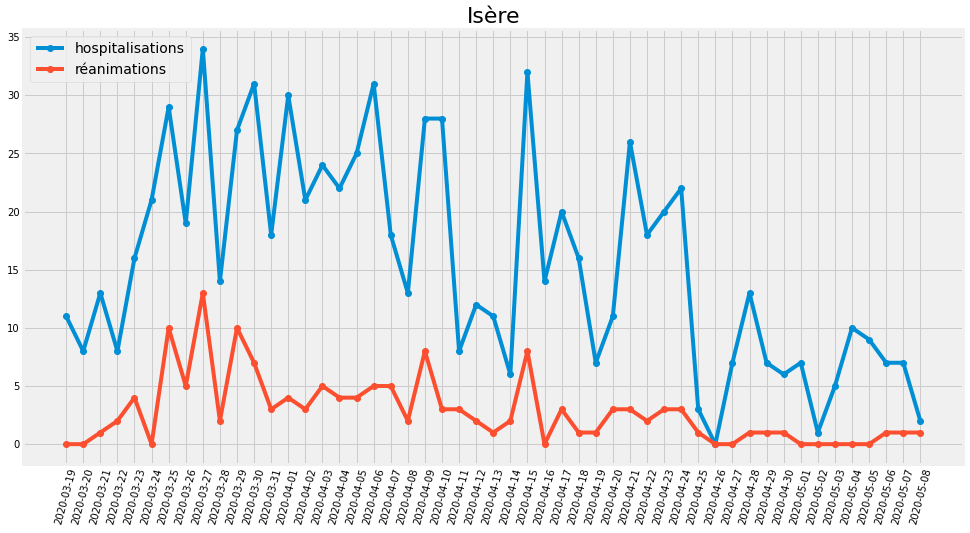

           dep        jour  incid_hosp  incid_rea  incid_dc  incid_rad
jour                                                                  
2020-05-04  38  2020-05-04          10          0         2          5
2020-05-05  38  2020-05-05           9          0         3          7
2020-05-06  38  2020-05-06           7          1         1         15
2020-05-07  38  2020-05-07           7          1         2          9
2020-05-08  38  2020-05-08           2          1         0          4


In [14]:
display_dept("38","Isère")

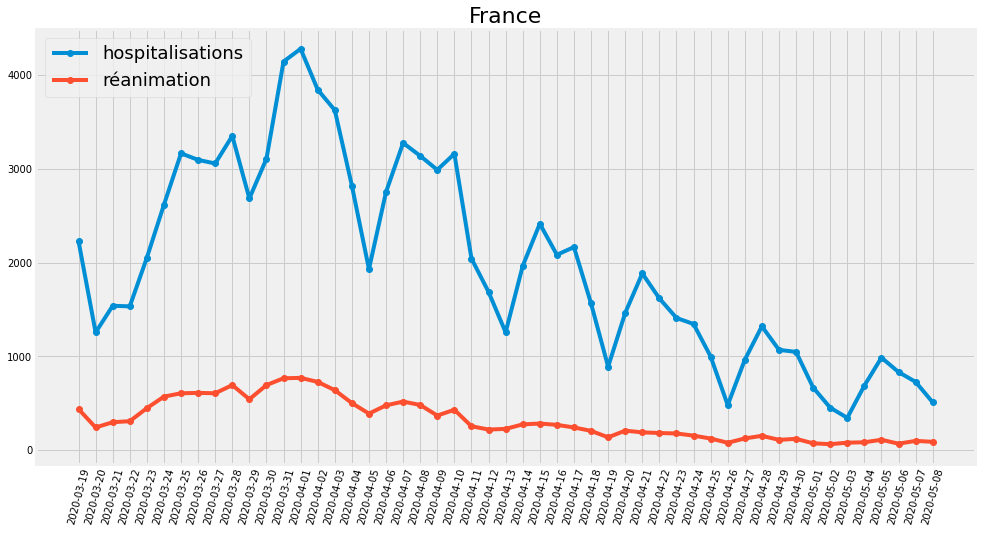

,incid_hosp,incid_rea,incid_dc,incid_rad
jour,,,,
2020-05-04,689,84,245,619
2020-05-05,987,111,244,1435
2020-05-06,833,69,181,1298
2020-05-07,728,99,159,1291
2020-05-08,510,89,118,817


In [8]:
daily = df.groupby(["jour"]).sum() 
plt.figure(figsize=(15,8))
plt.plot(daily[["incid_hosp", "incid_rea"]], marker="o")
plt.xticks(rotation=75)
plt.title("France", fontsize=22)
plt.legend(["hospitalisations", "réanimation"], loc=2, fontsize=18)
plt.show()
daily.tail()

In [11]:
hospitalisations_quoti = daily["incid_hosp"][-7:].mean()
print("hospitalisations quoti", hospitalisations_quoti)
hospitalisations_hebdo = hospitalisations_quoti * 7
print("hospitalisations hebdo", hospitalisations_hebdo)
infections_hebdo = hospitalisations_hebdo * 10
ratio_tests = infections_hebdo / 700000
print("infections/tests :",ratio_tests)

hospitalisations quoti 672.3333333333334
hospitalisations hebdo 4706.333333333334
infections/tests : 0.06723333333333335


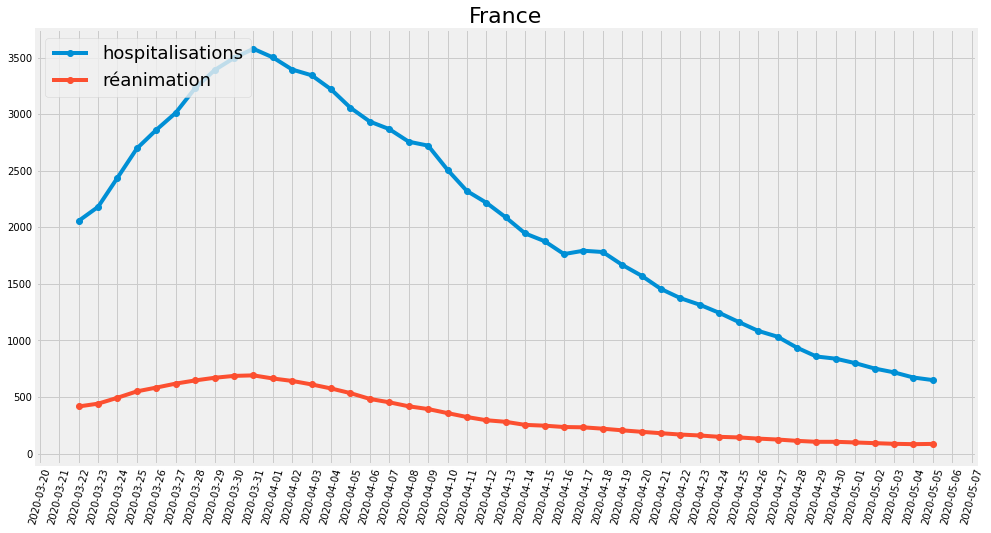

,incid_hosp,incid_rea,incid_dc,incid_rad
jour,,,,
2020-05-04,671.857143,82.857143,169.714286,875.857143
2020-05-05,649.285714,85.142857,166.857143,869.428571
2020-05-06,NaN,NaN,NaN,NaN
2020-05-07,NaN,NaN,NaN,NaN
2020-05-08,NaN,NaN,NaN,NaN


In [13]:
daily = df.groupby(["jour"]).sum().rolling(7, center=True).mean()
plt.figure(figsize=(15,8))
plt.plot(daily[["incid_hosp", "incid_rea"]], marker="o")
plt.xticks(rotation=75)
plt.title("France", fontsize=22)
plt.legend(["hospitalisations", "réanimation"], loc=2, fontsize=18)
plt.show()
daily.tail()